In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tkinter as tk
from PIL import Image, ImageDraw

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from scipy.ndimage import rotate, shift, zoom

In [2]:
from model.neural_network import NeuralNetwork
from model.layers.dense import DenseLayer
from model.layers.dropout import DropoutLayer
from model.optimizers.adam import Adam

# MNIST Dataset

In [3]:
mnist = fetch_openml('mnist_784')
X = mnist['data'].to_numpy() / 255.0
y = mnist['target'].astype(int).to_numpy()

x_train, x_test, y_train, y_test = train_test_split(
    X, y,
    test_size=10000,
    random_state=42,
    stratify=y
)

In [4]:
def noisy_image(image, img_size=28):
    if len(image.shape) == 1:
        img = image.reshape(img_size, img_size)
    else:
        img = image.copy()

    # Random rotation (-20 to +20 degrees)
    angle = np.random.uniform(-20, 20)
    img = rotate(img, angle, reshape=False, mode='constant', cval=0)

    # Random scaling (0.8 to 1.2)
    scale = np.random.uniform(0.8, 1.2)
    if scale != 1.0:
        zoomed = zoom(img, scale, order=1, mode='constant', cval=0)

        if scale > 1.0:
            start = (zoomed.shape[0] - img_size) // 2
            img = zoomed[start:start+img_size, start:start+img_size]
        else:
            pad_total = img_size - zoomed.shape[0]
            pad_before = pad_total // 2
            pad_after = pad_total - pad_before
            img = np.pad(zoomed, ((pad_before, pad_after), (pad_before, pad_after)), mode='constant', constant_values=0)

    # Random offset (-4 to +4 pixels)
    shift_x = np.random.uniform(-4, 4)
    shift_y = np.random.uniform(-4, 4)
    img = shift(img, [shift_y, shift_x], mode='constant', cval=0)

    # Add random noise (gaussian noise with small std)
    std = np.random.uniform(0, 0.1)
    noise = np.random.normal(0, std, img.shape)
    img = img + noise

    # Clip values to [0, 1] range
    img = np.clip(img, 0, 1)

    return img.flatten()


x_train = np.array([noisy_image(img) for img in x_train])

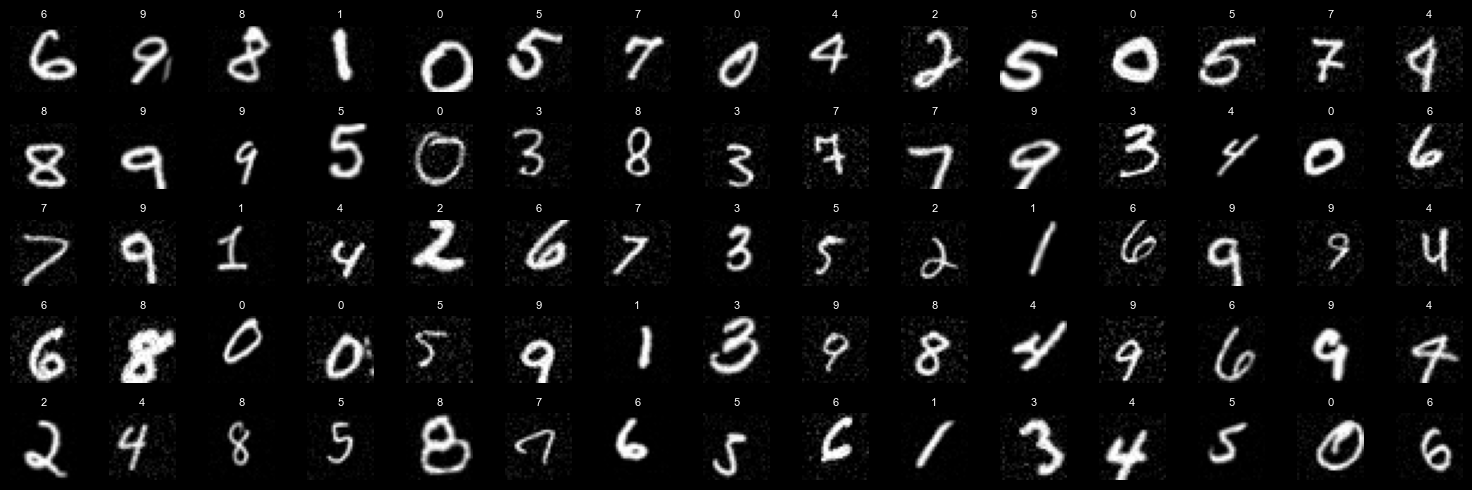

In [5]:
num_images = 75
num_cols = 15
num_rows = num_images // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title(str(y_train[i]), fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
x_train

array([[7.27083094e-02, 5.38711345e-02, 0.00000000e+00, ...,
        0.00000000e+00, 9.00170517e-05, 6.40608828e-02],
       [1.72374187e-02, 0.00000000e+00, 4.71206628e-05, ...,
        4.11735308e-03, 0.00000000e+00, 3.21464520e-03],
       [8.63826343e-03, 4.43055684e-03, 0.00000000e+00, ...,
        0.00000000e+00, 3.83195198e-02, 2.12700112e-03],
       ...,
       [0.00000000e+00, 3.91392012e-02, 0.00000000e+00, ...,
        9.40975928e-03, 0.00000000e+00, 5.56180393e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.64985460e-02, 2.86666534e-02],
       [0.00000000e+00, 0.00000000e+00, 7.18117245e-02, ...,
        0.00000000e+00, 0.00000000e+00, 8.70229103e-02]],
      shape=(60000, 784))

# Training

In [7]:
def to_categorical(y, num_classes):
    y = np.asarray(y, dtype=int)
    return np.eye(num_classes)[y]

In [8]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

model = NeuralNetwork([
    DenseLayer(784, 128, activation='Relu', weight_regularizer_l2=1e-4, bias_regularizer_l2=5e-4),
    DropoutLayer(rate=0.1),
    DenseLayer(128, 64, activation='Relu'),
    DropoutLayer(rate=0.1),
    DenseLayer(64, 10, activation='Softmax')
])

model.set(
    loss='CategoricalCrossentropy',
    optimizer=Adam(learning_rate=0.001, decay=1e-5)
)

model.train(x_train, y_train, epochs=1000, print_every=5, validation_data=(x_test, y_test), patience=10, min_delta=0.005)

predictions = model.forward(x_test)
accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1))
print(f"Test Accuracy: {accuracy:.4f}")

epoch: 0, loss: 2.30767, acc: 10.59%, lr: 0.0010000000
epoch: 5, loss: 2.30016, acc: 35.12%, lr: 0.0009999600
epoch: 10, loss: 2.27241, acc: 25.12%, lr: 0.0009999100
epoch: 15, loss: 2.19512, acc: 34.41%, lr: 0.0009998600
epoch: 20, loss: 2.05860, acc: 45.60%, lr: 0.0009998100
epoch: 25, loss: 1.87506, acc: 50.45%, lr: 0.0009997601
epoch: 30, loss: 1.68138, acc: 56.14%, lr: 0.0009997101
epoch: 35, loss: 1.52645, acc: 57.88%, lr: 0.0009996601
epoch: 40, loss: 1.44571, acc: 58.10%, lr: 0.0009996102
epoch: 45, loss: 1.41224, acc: 57.83%, lr: 0.0009995602
epoch: 50, loss: 1.38007, acc: 58.45%, lr: 0.0009995102
epoch: 55, loss: 1.33435, acc: 60.08%, lr: 0.0009994603
epoch: 60, loss: 1.29068, acc: 61.66%, lr: 0.0009994103
epoch: 65, loss: 1.23885, acc: 63.39%, lr: 0.0009993604
epoch: 70, loss: 1.18682, acc: 65.73%, lr: 0.0009993105
epoch: 75, loss: 1.11618, acc: 67.82%, lr: 0.0009992605
epoch: 80, loss: 1.05414, acc: 69.67%, lr: 0.0009992106
epoch: 85, loss: 0.99130, acc: 72.34%, lr: 0.00099

# Testing

In [9]:
class DigitRecognizer:
    def __init__(self, model):
        self.model = model
        self.window = tk.Tk()
        self.window.title('Draw a Digit')

        self.canvas = tk.Canvas(self.window, width=280, height=280, bg='black')
        self.canvas.pack()

        self.button_frame = tk.Frame(self.window)
        self.button_frame.pack()

        self.predict_button = tk.Button(self.button_frame, text='Predict', command=self.predict_digit)
        self.predict_button.pack(side='left')

        self.clear_button = tk.Button(self.button_frame, text='Clear', command=self.clear_canvas)
        self.clear_button.pack(side='right')

        self.canvas.bind('<B1-Motion>', self.draw)

        self.image = Image.new('L', (280, 280), color=0)
        self.draw_image = ImageDraw.Draw(self.image)

        self.pixel_size = 10  # Size of each "pixel" square

        self.window.mainloop()

    def draw(self, event):
        x, y = event.x, event.y

        # Snap to grid
        grid_x = (x // self.pixel_size) * self.pixel_size
        grid_y = (y // self.pixel_size) * self.pixel_size

        self.canvas.create_rectangle(
            grid_x, grid_y,
            grid_x + self.pixel_size, grid_y + self.pixel_size,
            fill='white', outline='white'
        )

        self.draw_image.rectangle(
            [grid_x, grid_y, grid_x + self.pixel_size, grid_y + self.pixel_size],
            fill=255
        )

    def clear_canvas(self):
        self.canvas.delete('all')
        self.draw_image.rectangle([0, 0, 280, 280], fill=0)

    def predict_digit(self):
        resized = self.image.resize((28, 28))
        data = np.asarray(resized).astype(np.float32) / 255.0
        data = data.reshape(1, -1)

        prediction = self.model.forward(data)
        predicted_class = np.argmax(prediction)
        print(f"Predicted digit: {predicted_class}")

        self.window.title(f"Predicted digit: {predicted_class}")

In [10]:
DigitRecognizer(model)

Predicted digit: 1
Predicted digit: 2
Predicted digit: 3
Predicted digit: 4
Predicted digit: 5
Predicted digit: 6
Predicted digit: 7
Predicted digit: 8
Predicted digit: 9
Predicted digit: 0
